In [2]:
import ee


In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize()

# Our area of interest (AOI) is University Of Jeddah

In [5]:
# Define the Area of Interest (AOI) as a Polygon in Python for UJ
aoi = ee.Geometry.Polygon([
    [
        [39.24781494969205, 21.88731024190632],  # Bottom Left
        [39.280945595444, 21.88731024190632],    # Bottom Right
        [39.280945595444, 21.916058795347105],   # Top Right
        [39.24781494969205, 21.916058795347105], # Top Left
        [39.24781494969205, 21.88731024190632]   # Closing the loop
    ]
])


# Now, will check on this AOI or (ROI)

In [6]:
from IPython.display import Image

In [7]:
# Select a Sentinel-2 image
sentinel2 = ee.Image(ee.ImageCollection('COPERNICUS/S2')
                     .filterBounds(aoi)
                     .filterDate('2023-01-01', '2023-12-31')
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                     .first())

# Visualization parameters for Sentinel-2
vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2'],  # RGB
}

# Overlay the AOI on the Sentinel-2 image
aoi_layer = ee.Image().paint(featureCollection=aoi, color=1, width=3)
composite = sentinel2.visualize(**vis_params).blend(aoi_layer.visualize(**{'palette': 'FF0000'}))

# Get the URL for the thumbnail of the composite image
thumbnail_url = composite.getThumbURL({
    'region': aoi.bounds().getInfo()['coordinates'],
    'dimensions': 512
})

# Display the image directly in the notebook
display(Image(url=thumbnail_url))

# another way using Filium library 

In [8]:
import folium


In [9]:
# Your AOI coordinates, with the order corrected for Folium ([latitude, longitude])
aoi_coordinates = [
    [21.88731024190632, 39.24781494969205],  # Bottom Left
    [21.88731024190632, 39.280945595444],    # Bottom Right
    [21.916058795347105, 39.280945595444],   # Top Right
    [21.916058795347105, 39.24781494969205], # Top Left
    [21.88731024190632, 39.24781494969205]   # Closing the loop
]

# Calculate the center of your AOI for the map's initial view
lat_center = sum(lat for lat, lon in aoi_coordinates) / len(aoi_coordinates)
lon_center = sum(lon for lat, lon in aoi_coordinates) / len(aoi_coordinates)

# Create a Folium map centered around the middle of the AOI
m = folium.Map(location=[lat_center, lon_center], zoom_start=15)

# Add a polygon overlay to the map using the AOI coordinates
folium.Polygon(
    locations=aoi_coordinates,  # Use the AOI coordinates directly
    color='blue',
    weight=3,
    fill_color='blue',
    fill_opacity=0.1,
).add_to(m)

# Display the map
m

# Now, will extract one image for this AOI (UJ)

In [10]:
# Filter the Sentinel-2 ImageCollection for images within the AOI and time frame, and compute the median
sentinelCollection = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterDate('2024-01-01', '2024-01-30') \
    .filterBounds(aoi) \
    .median()

# Clip the median image to the AOI
clippedImage = sentinelCollection.clip(aoi)

# Function to cast all bands to Float32
def castImage(image):
    return image.toFloat()

# Cast all bands of the clipped image to Float32
castedImage = castImage(clippedImage)


 #Export the casted image, specifying scale and region (this is an example, see below for details)
task = ee.batch.Export.image.toDrive(**{
   'image': castedImage,
   'description': '22-UJ-24-01-30-Full-Bands',
   'scale': 10,
   'region': aoi.getInfo()['coordinates'],
   'fileFormat': 'GeoTIFF',
   'maxPixels': 1e9
 })
task.start()

 # congrats!!! Now you can download it as .tif file from Google Drive

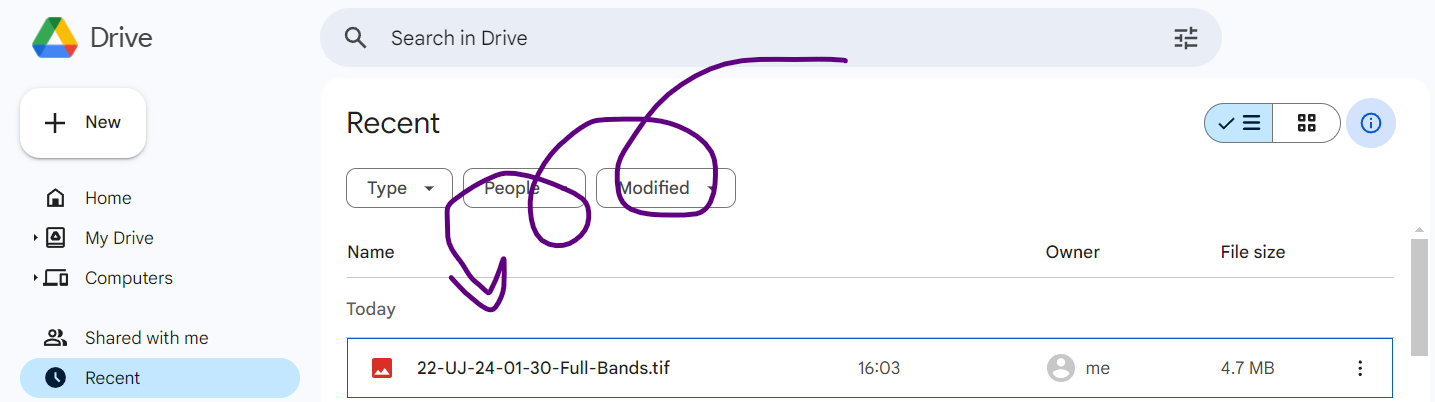

# Now, will extract images from 2018/12 till 2024/01

In [11]:

import datetime
# Function to cast all bands to Float32
def castImage(image):
    return image.toFloat()

# Function to export images
def exportImage(image, date):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=f'UJ_{date.strftime("%Y-%m-%d")}',
        scale=10,
        region=aoi.getInfo()['coordinates'],
        fileFormat='GeoTIFF',
        maxPixels=1e9
    )
    task.start()

# Start and end dates
start_date = datetime.datetime(2018, 12, 15)
end_date = datetime.datetime(2024, 1, 30)

# Generate images every 15 days
current_date = start_date
while current_date <= end_date:
    # Define the date range for the current image
    date_range_start = current_date.strftime('%Y-%m-%d')
    next_date = current_date + datetime.timedelta(days=15)
    date_range_end = next_date.strftime('%Y-%m-%d')

    # Get the image collection for the current date range
    sentinelCollection = ee.ImageCollection("COPERNICUS/S2_SR") \
        .filterDate(date_range_start, date_range_end) \
        .filterBounds(aoi) \
        .median()

    # Clip the image to the AOI
    clippedImage = sentinelCollection.clip(aoi)

    # Cast all bands of the clipped image to Float32
    castedImage = castImage(clippedImage)

    # Export the casted image
    exportImage(castedImage, current_date)

    # Update the current date
    current_date = next_date

print("Images export tasks started.")

Images export tasks started.
